### Importing the data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Project/Sarcasm_Headlines_Dataset.json', lines = True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.shape

(28619, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [8]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

              headline  article_link
is_sarcastic                        
0                14985         14985
1                13634         13634


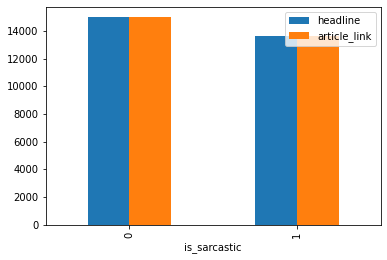

In [9]:
print(df.groupby(['is_sarcastic']).count())
df.groupby(['is_sarcastic']).count().plot(kind = 'bar')

Sarcastic and non-sarcastic are almost balanced.

###  Retain the important column

In [10]:
df['headline_modified'] = df['headline'].apply(lambda x : re.sub('[^A-Za-z]+',  ' ', x))
df['headline_modified'] = df['headline_modified'].apply(lambda x : x.strip())
df['headline_modified'] = df['headline_modified'].apply(lambda x : x.lower())

In [11]:
df.sample(5)

,is_sarcastic,headline,article_link,headline_modified
5656,1,hollywood removes statue of louis b. mayer bec...,https://entertainment.theonion.com/hollywood-r...,hollywood removes statue of louis b mayer beck...
6615,0,merkel: isis poses major risk to europe,https://www.huffingtonpost.com/entry/merkel-is...,merkel isis poses major risk to europe
22009,0,big brothers big sisters honors nbc entertainm...,https://www.huffingtonpost.com/entry/big-broth...,big brothers big sisters honors nbc entertainm...
14293,1,trump called up for vietnam service after last...,https://politics.theonion.com/trump-called-up-...,trump called up for vietnam service after last...
26971,0,radical islamist preacher anjem choudary found...,https://www.huffingtonpost.com/entry/anjem-cho...,radical islamist preacher anjem choudary found...


In [12]:
df.drop(['article_link', 'headline'], axis = 1, inplace = True)

### Length of the sentence 

In [13]:
sarcastic = df.loc[df['is_sarcastic'] == 1]
sarcastic_text = ' '.join(text for text in sarcastic['headline_modified'])
print('The length of combined sarcastic text is:', len(sarcastic_text))

The length of combined sarcastic text is: 890962


In [14]:
non_sarcastic = df.loc[df['is_sarcastic'] == 0]
non_sarcastic_text = ' '.join(text for text in non_sarcastic['headline_modified'])
print('The length of combined non-sarcastic text is:', len(non_sarcastic_text))

The length of combined non-sarcastic text is: 886589


In [15]:
line_len = df['headline_modified'].str.len()
print('Mininmum length of line:', line_len.min())
print('Maximum length of line:', line_len.max())

Mininmum length of line: 4
Maximum length of line: 911


In [16]:
word_len = df['headline_modified'].apply(lambda x: len(x.split(' ')))
print('Mininmum length of word:', word_len.min())
print('Maximum length of word:', word_len.max())

Mininmum length of word: 1
Maximum length of word: 152


### Parameters

In [17]:
maxlen = len(df['headline_modified'].max())

In [18]:
max([len(headline.split()) for headline in df['headline_modified']])

152

In [19]:
max_features = 10000
maxlen = maxlen
embedding_size = 50

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', max_features = 5000)
vect.fit(df['headline_modified'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [49]:
list(vect.vocabulary_.items())[:20]

[('scientists', 3925),
 ('unveil', 4718),
 ('clock', 837),
 ('hair', 1984),
 ('loss', 2671),
 ('rep', 3699),
 ('totally', 4576),
 ('nails', 2971),
 ('congress', 930),
 ('falling', 1613),
 ('short', 4056),
 ('gender', 1842),
 ('racial', 3560),
 ('equality', 1504),
 ('eat', 1411),
 ('different', 1256),
 ('recipes', 3630),
 ('weather', 4861),
 ('liar', 2589),
 ('getting', 1857)]

### Features and labels

In [20]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(df['headline_modified']))

In [21]:
X = tokenizer.texts_to_sequences(df['headline_modified'])
X = pad_sequences(X, maxlen = maxlen)

In [22]:
y = np.asarray(df['is_sarcastic'])

In [23]:
len(X)

28619

In [24]:
len(y)

28619

### Vocabulary size

In [25]:
num_words = len(tokenizer.word_index) + 1
print('Vocabulary size:', num_words)

Vocabulary size: 25916


### GloVe embeddings 

In [26]:
embedding_file = '/content/drive/MyDrive/Colab Notebooks/Lab/glove.6B.50d.txt'
embeddings = {}
for o in open(embedding_file, encoding = 'utf8'):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.array(embd, dtype = 'float32')
    embeddings[word] = embd

In [27]:
len(embeddings.values())

400000

In [28]:
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
len(embedding_matrix)

25916

### LSTM model 

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3, test_size = 0.3)

In [31]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length = maxlen))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 47, 50)            1295800   
_________________________________________________________________
bidirectional (Bidirectional (None, 47, 256)           183296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [33]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5
157/157 [==============================] - 58s 342ms/step - loss: 0.5036 - accuracy: 0.7458 - val_loss: 0.3812 - val_accuracy: 0.8289
Epoch 2/5
157/157 [==============================] - 53s 335ms/step - loss: 0.3238 - accuracy: 0.8592 - val_loss: 0.3495 - val_accuracy: 0.8507
Epoch 3/5
157/157 [==============================] - 53s 338ms/step - loss: 0.2312 - accuracy: 0.9056 - val_loss: 0.3147 - val_accuracy: 0.8693
Epoch 4/5
157/157 [==============================] - 53s 336ms/step - loss: 0.1562 - accuracy: 0.9407 - val_loss: 0.3394 - val_accuracy: 0.8706
Epoch 5/5
157/157 [==============================] - 53s 335ms/step - loss: 0.1032 - accuracy: 0.9630 - val_loss: 0.3720 - val_accuracy: 0.8685


### Evaluation

In [37]:
model.evaluate(X_test, y_test)

269/269 [==============================] - 7s 26ms/step - loss: 0.3720 - accuracy: 0.8685


[0.372018426656723, 0.8685068488121033]

<Figure size 432x288 with 0 Axes>

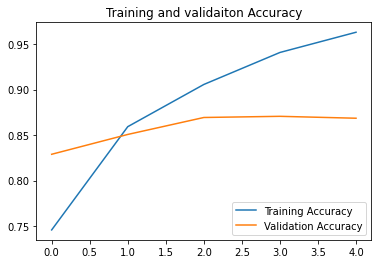

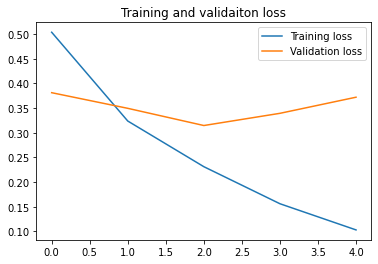

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
plt.title('Training and validaiton Accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('Training and validaiton loss')
plt.legend(loc = 'Top right')
plt.figure()

In [35]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4454
           1       0.89      0.83      0.86      4132

    accuracy                           0.87      8586
   macro avg       0.87      0.87      0.87      8586
weighted avg       0.87      0.87      0.87      8586



### Conclusion

We imported the data from the JSON format, then performed the data pre-processing. After that, we kept specific columns and found the length of the sentence. Next, we defined the parameters, split the data into features and labels and found the vocabulary size. Then, we added Glove embedding and also put the embedding matrix. Next, we implemented the basic bidirectional LSTM architecture. The final result is that the validation accuracy is 86%. While the F1 scores for non-sarcastic are 88% and for sarcastic is 86%. The model is a little overfitted, but the results are adequate. The model can be better by getting the hyper-parameters and some new features into the architecture, for instance adding more layers.